# Financial Tweets Analysis NLP

This notebooks performs exploratory data analysis, topic modelling and sentiment analysis using the text from financial tweet data https://www.kaggle.com/davidwallach/financial-tweets

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams

from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report,confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv("C:/Users/imoge/Projects/Datasets/stockerbot-export.csv", index_col = 0, sep=',')

In [5]:
df.head(52)

,text,timestamp,source,symbols,company_names,url,verified,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
id,,,,,,,,,,,,,,,,
1.0197E+18,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.01971E+18,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.01971E+18,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.01972E+18,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.01972E+18,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.01972E+18,.@RealMoney's David Butler's favorite FANG sto...,Wed Jul 18 23:04:00 +0000 2018,jimcramer,FB-GOOGL-GOOG,Facebook*Alphabet*Alphabet,http://bit.ly/2NrYxje,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.01972E+18,Don’t miss my convo with one of my favorite th...,Wed Jul 18 23:06:58 +0000 2018,ianbremmer,HRS,Harris,https://twitter.com/samharrisorg/status/101971...,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.01972E+18,U.S. intelligence documents on Nelson Mandela ...,Wed Jul 18 23:08:45 +0000 2018,Reuters,INTC-USB,Intel*U.S.,https://reut.rs/2O0ypNf,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.01972E+18,Senate wants emergency alerts to go out throug...,Wed Jul 18 23:09:00 +0000 2018,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(28440, 16)

In [7]:
df = df[['text','timestamp','source','symbols','company_names']]
df.reset_index(drop = True, inplace = True)

In [8]:
# Check for null values
df.isnull().sum()

text             0
timestamp        2
source           3
symbols          3
company_names    5
dtype: int64

In [9]:
# Drop rows with nulls
df = df.dropna()

In [10]:
df.shape

(28435, 5)

In [11]:
df.sample(5)

,text,timestamp,source,symbols,company_names
3192,📊 The 10 Best Performing S&amp;P 500 Stocks YT...,Thu Jul 12 13:05:11 +0000 2018,esimong,XL,XL Group Ltd
13733,Exploring different #socialmedia built on the ...,Tue Jul 17 12:19:16 +0000 2018,cryptoctopus777,SPN,Superior Energy Services
4539,Investors Buy Large Volume of Nuance Communica...,Fri Jul 13 07:07:40 +0000 2018,OlympiaReport,NUAN,Nuance Communications
27902,@AAF @djheakin You better read the rest of the...,Wed Jul 18 23:07:41 +0000 2018,RobTVDC,WFC,Wells Fargo & Company
20971,Barclays Reconfirmed Darden Restaurants $DRI A...,Wed Jul 18 13:36:57 +0000 2018,Fanob_stock,DRI,Darden Restaurants


In [12]:
print(df["text"].iloc[3])

Barry Silbert is extremely optimistic on bitcoin -- but predicts that 99% of new crypto entrants are “going to zero… https://t.co/mGMVo2cZgY


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28435 entries, 0 to 28439
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           28435 non-null  object
 1   timestamp      28435 non-null  object
 2   source         28435 non-null  object
 3   symbols        28435 non-null  object
 4   company_names  28435 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


In [14]:
# Split out the date information
df[['Day_week','Month','Day','Time','Timezone', 'Year']] = df.timestamp.str.split(expand=True)
df[['Hour','Minute','Second']] = df.Time.str.split(':',expand=True)
df.drop(columns = ["timestamp"],axis = 1, inplace = True)
df.head(2)

,text,source,symbols,company_names,Day_week,Month,Day,Time,Timezone,Year,Hour,Minute,Second
0,VIDEO: “I was in my office. I was minding my o...,GoldmanSachs,GS,The Goldman Sachs,Wed,Jul,18,21:33:26,+0000,2018,21,33,26
1,The price of lumber $LB_F is down 22% since hi...,StockTwits,M,Macy's,Wed,Jul,18,22:22:47,+0000,2018,22,22,47


# Exploratory Data Analysis

## Number of Tweets by Company Names

In [15]:
companies = df["company_names"].value_counts()
companies_top = pd.DataFrame(companies.head(15)).reset_index()
companies_top.columns = ["Company","Number of Tweets"]
companies_top

,Company,Number of Tweets
0,Twenty-First Century Fox,132
1,Alphabet Inc.,116
2,Discovery,104
3,Netflix,101
4,Applied Materials,100
5,Honeywell International Inc.,100
6,Momo Inc.,100
7,The Gap,100
8,M&T Bank Corporation,100
9,Eversource Energy,100


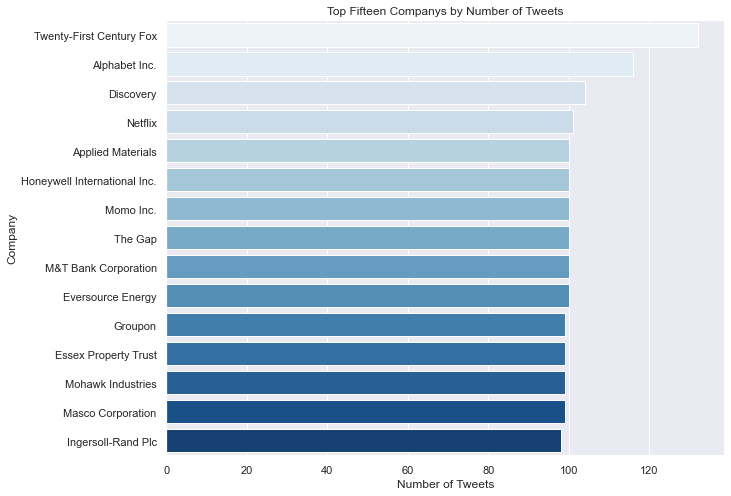

In [16]:
fig, ax = plt.subplots(figsize = (10,8))
sns.barplot(data = companies_top, y = "Company", x = "Number of Tweets", palette = "Blues")
plt.title("Top Fifteen Companys by Number of Tweets");

In [17]:
companies_bot = pd.DataFrame(companies.tail(15)).reset_index()
companies_bot.columns = ["Company","Number of Tweets"]
companies_bot

,Company,Number of Tweets
0,Alphabet,1
1,Amazon*The Gap,1
2,Facebook*Alphabet*Alphabet,1
3,JD,1
4,Intel*U.S.,1
5,Twitter,1
6,Time Warner,1
7,MGM Resorts,1
8,American,1
9,Harris,1


## Number of Tweets by Source

In [18]:
source = df["source"].value_counts()
source = pd.DataFrame(source.head(15)).reset_index()
source.columns = ["Source","Number of Tweets"]
source

,Source,Number of Tweets
0,bibeypost_stock,990
1,whatsonthorold2,963
2,mmahotstuff1,899
3,reurope_stock,668
4,MareaInformativ,640
5,optioncharts,614
6,ConsumerFeed,411
7,dispatchtribune,381
8,EnterpriseLeade,368
9,OlympiaReport,367


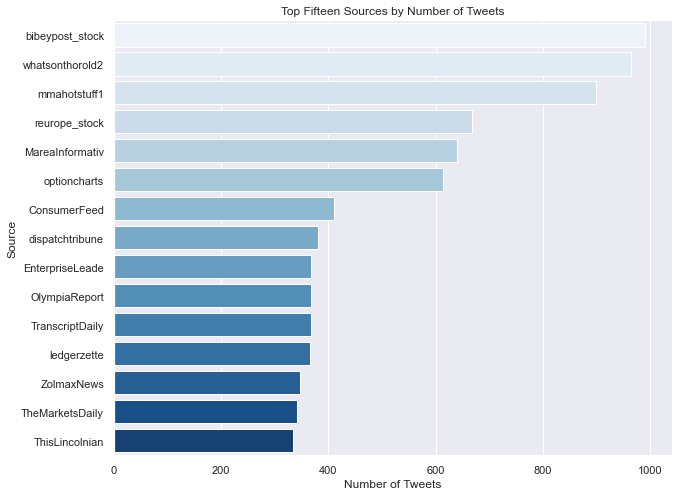

In [19]:
fig, ax = plt.subplots(figsize = (10,8))
sns.barplot(data = source, y = "Source", x = "Number of Tweets", palette = "Blues")
plt.title("Top Fifteen Sources by Number of Tweets");

## Number of Tweets by Time Period

In [20]:
df.columns

Index(['text', 'source', 'symbols', 'company_names', 'Day_week', 'Month',
       'Day', 'Time', 'Timezone', 'Year', 'Hour', 'Minute', 'Second'],
      dtype='object')

In [21]:
df["Year"].value_counts()

2018    28435
Name: Year, dtype: int64

In [22]:
df["Month"].value_counts()

Jul    28434
Feb        1
Name: Month, dtype: int64

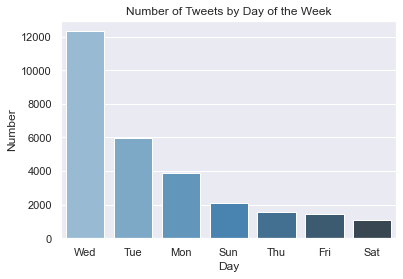

In [23]:
day = pd.DataFrame(df["Day_week"].value_counts()).reset_index()
day.columns = ["Day","Number"]
sns.barplot(data = day, x = "Day", y = "Number",palette = "Blues_d")
plt.title("Number of Tweets by Day of the Week");

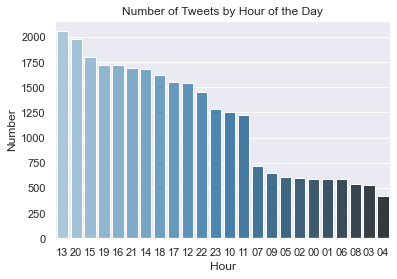

In [24]:
hour = pd.DataFrame(df["Hour"].value_counts()).reset_index()
hour.columns = ["Hour","Number"]
sns.barplot(data = hour, x = "Hour", y = "Number",palette = "Blues_d")
plt.title("Number of Tweets by Hour of the Day");

Most tweets are made in the afternoon and evening and the least in the early hours of the morning

In [25]:
# Average number of tweets per hour
hour["Number"].sum()/24

1184.7916666666667

## Explore Text

In [26]:
# Check the length of the tweets
df["len_text"] = df["text"].apply(lambda x: len(x))

In [27]:
# Look at the average, max and min characters
df["len_text"].describe()

count    28435.000000
mean       110.627642
std        182.633723
min          2.000000
25%         87.000000
50%        114.000000
75%        137.000000
max      24561.000000
Name: len_text, dtype: float64

In [28]:
# Find tweets over 200 characters
df[df["len_text"] >200]

,text,source,symbols,company_names,Day_week,Month,Day,Time,Timezone,Year,Hour,Minute,Second,len_text
3127,Novice Traders trade 5 to 10 times too big. Th...,WaltBTIG,MSI,Motorola Solutions,Thu,Jul,12,12:34:09,+0000,2018,12,34,09,24561
4221,The report is excellent in terms of record pro...,NWRcomms,PRU,Prudential Financial,Fri,Jul,13,00:18:39,+0000,2018,00,18,39,3948
8045,has lifted the United States above Saudi Arabi...,lasertrader,CBS,CBS Corporation,Sun,Jul,15,15:19:53,+0000,2018,15,19,53,17651
26369,Rhodes posted her petition [about alleged sexu...,Union_Los,CMCSA,Comcast Corporation,Wed,Jul,18,21:05:28,+0000,2018,21,05,28,1760


In [69]:
# Longest characters looks like multiple tweets not split correctly
#print(df["text"].iloc[3127])

In [30]:
df2 = df[["text"]]

In [31]:
df2.head()

,text
0,VIDEO: “I was in my office. I was minding my o...
1,The price of lumber $LB_F is down 22% since hi...
2,Who says the American Dream is dead? https://t...
3,Barry Silbert is extremely optimistic on bitco...
4,How satellites avoid attacks and space junk wh...


## Clean Text

In [32]:
# Set text to lower case
df2["text"] = df2["text"].apply(lambda x: x.lower())

In [33]:
# Remove stopwords, twitter links - credit to BENOIT CANTE (Kaggle)
stop = stopwords.words('english')
stop.append("rt") # RT for retweet
url_regex = "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"  # URL
handle_regex= "^@?(\w){1,15}$"  # Twitter handle

df2['text']=df2['text'].str.replace(url_regex, '')
df2['text']=df2['text'].str.replace(handle_regex, '')

df2['text']=df2['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [34]:
df2.head()

,text
0,video: “i office. minding business...” –david ...
1,price lumber $lb_f 22% since hitting ytd highs...
2,says american dream dead?
3,barry silbert extremely optimistic bitcoin -- ...
4,satellites avoid attacks space junk circling e...


In [35]:
# Tokenize the text
df2["text"] = df2["text"].apply(lambda x: nltk.word_tokenize(x))

In [36]:
# Remove punctuation
punc = string.punctuation
df2["text"] = df2["text"].apply(lambda x: [word for word in x if word not in punc])

In [37]:
# Remove non ascii characters
df2["text"] = df2["text"].apply(lambda x: [e for e in x if e.encode("ascii","ignore")])

In [38]:
# Remove numbers
df2["text"] = df2["text"].apply(lambda x: [n for n in x if not n.isnumeric()])

In [39]:
df2.head()

,text
0,"[video, i, office, minding, business, ..., –da..."
1,"[price, lumber, lb_f, since, hitting, ytd, hig..."
2,"[says, american, dream, dead]"
3,"[barry, silbert, extremely, optimistic, bitcoi..."
4,"[satellites, avoid, attacks, space, junk, circ..."


## Most Frequent Words

In [40]:
# Find the most frequent words and visualise these words
df2["count"] = df2["text"].apply(lambda x: Counter(x))

In [41]:
df2.head(2)

,text,count
0,"[video, i, office, minding, business, ..., –da...","{'video': 1, 'i': 1, 'office': 1, 'minding': 1..."
1,"[price, lumber, lb_f, since, hitting, ytd, hig...","{'price': 1, 'lumber': 1, 'lb_f': 1, 'since': ..."


In [42]:
print(df2["count"].iloc[0])

Counter({'video': 1, 'i': 1, 'office': 1, 'minding': 1, 'business': 1, '...': 1, '–david': 1, 'solomon': 1, 'tells': 1, 'gs': 1, 'interns': 1, 'learned': 1, 'wa…': 1})


In [43]:
counter_df = pd.DataFrame(df2["count"].sum().most_common(100),columns = ["Word","Count"])
counter_df.head()

,Word,Count
0,amp,3004
1,inc,2007
2,inc.,1936
3,earnings,1838
4,stock,1796


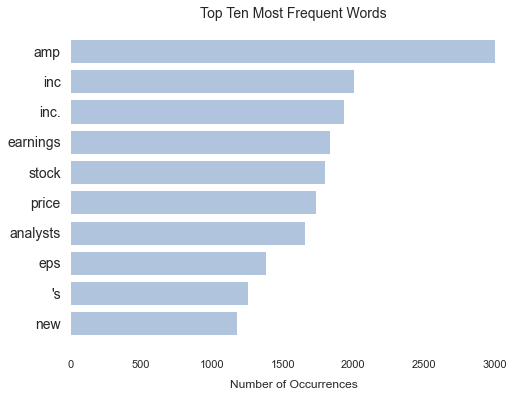

In [44]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_facecolor("White")
counter_top = counter_df.sort_values(by = "Count",ascending = False).head(10)
ax.barh(counter_top["Word"], width = counter_top["Count"], color = "lightsteelblue")
ax.set_title("Top Ten Most Frequent Words",fontsize = 14)
ax.invert_yaxis()
ax.set_xlabel("Number of Occurrences",labelpad = 10)
plt.yticks(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [45]:
stopwords = list(STOPWORDS)
words = " ".join(x for x in counter_df.Word)
wc = WordCloud(stopwords=stopwords, background_color="white").generate(words)

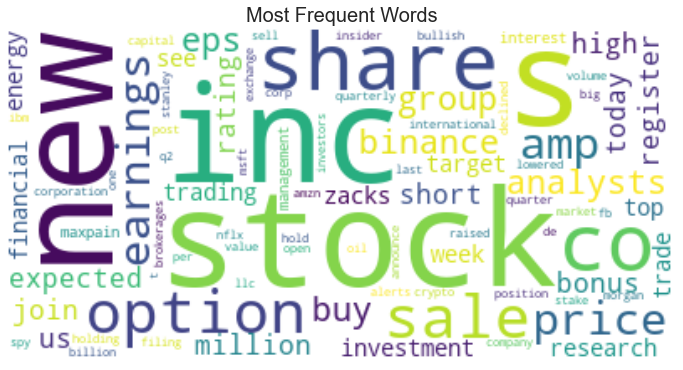

In [46]:
# Display the generated image: Hotels positive words
plt.figure(figsize=[12,10])
plt.title("Most Frequent Words", fontsize = 20)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Most Frequent Bigrams

In [54]:
df2["bigrams"] = df2["text"].apply(lambda x: ngrams(x,2))
df2["bigrams_count"] = df2["bigrams"].apply(Counter)

In [65]:
bigrams = pd.DataFrame(df2["bigrams_count"].sum().most_common(),columns = ["Bigram","Count"])
bigrams["Bigram"] = bigrams["Bigram"].apply(lambda x: ' '.join(x))

In [66]:
bigrams.head()

,Bigram,Count
0,register bonus,957
1,join us,691
2,per share,551
3,maxpain options,530
4,price target,513


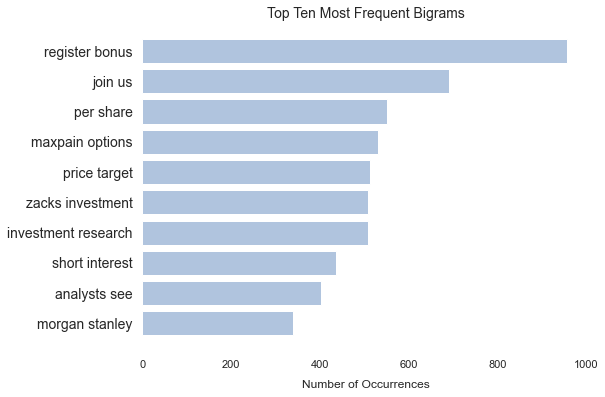

In [67]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_facecolor("White")
bigrams_top = bigrams.sort_values(by = "Count",ascending = False).head(10)
ax.barh(bigrams_top["Bigram"], width = bigrams_top["Count"], color = "lightsteelblue")
ax.set_title("Top Ten Most Frequent Bigrams",fontsize = 14)
ax.invert_yaxis()
ax.set_xlabel("Number of Occurrences",labelpad = 10)
plt.yticks(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

## Find the Main Topics Based on Topic Modelling

In [75]:
# Create word string before vectorizing
bigrams_joined = bigrams["Bigram"]
bigrams_joined = bigrams_joined.apply(lambda x:''.join(x))

In [82]:
# Create vectorized text
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vector = tf_idf_vectorizer.fit_transform(bigrams_joined)

In [111]:
# Set up LDA model (try ten topics as per default - NOTE different numbers can be tried and the perplexity or log likelihood
# scores compared)

topics = 10
method = "online"

lda_model = LatentDirichletAllocation(n_components = topics, 
                                      random_state = 42, 
                                      learning_method = method)
dtm = lda_model.fit_transform(tfidf_vector)

In [120]:
# Create document topic matrix and add likely topics based on the highest tfidf weightings
df_dtm = pd.DataFrame(dtm)
df_dtm["Topic"] = df_dtm.idxmax(axis = 1)
df_dtm.head()

,0,1,2,3,4,5,6,7,8,9,Topic
0,0.036786,0.036786,0.491337,0.214374,0.036786,0.036786,0.036786,0.036786,0.036786,0.036786,2
1,0.203916,0.037135,0.499006,0.037135,0.037135,0.037135,0.037135,0.037135,0.037135,0.037135,2
2,0.037201,0.037201,0.037201,0.495435,0.037201,0.037201,0.037201,0.037201,0.037201,0.206957,3
3,0.037030,0.037030,0.037030,0.037030,0.037030,0.211674,0.037030,0.037030,0.037030,0.492085,9
4,0.037654,0.037654,0.037654,0.037654,0.661111,0.037654,0.037654,0.037654,0.037654,0.037654,4


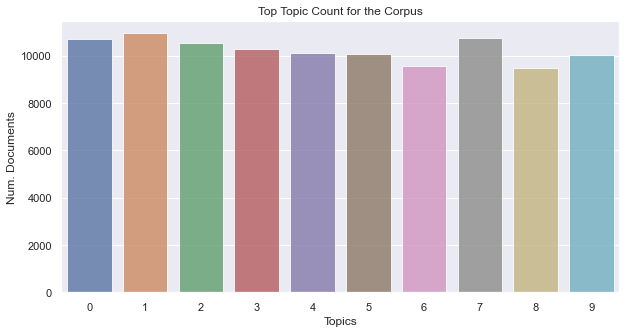

In [121]:
# Obtain value counts per topic and plot
x = pd.DataFrame(df_dtm["Topic"].value_counts())
x.T
plt.figure(figsize=(10,5))
sns.barplot(x.index, x.Topic, alpha=0.8)
plt.title("Top Topic Count for the Corpus")
plt.ylabel("Num. Documents")
ax = plt.xlabel("Topics")

With the ten topics used in the model, they are all very similar in terms of the numbers of documents allocated to each topic.It may be that more topics would be better.

In [129]:
# Get the Word Topic matrix and convert to probabilities
wtm = lda_model.components_
wtm/=wtm.sum(axis = 1)[:,np.newaxis]

ind = ["Topic1","Topic2","Topic3","Topic4","Topic5","Topic6","Topic7","Topic8","Topic9","Topic10"]
df_word_prob = pd.DataFrame(wtm, columns = [tf_idf_vectorizer.get_feature_names()], index = ind)
df_word_prob["Prob"] = df_word_prob.iloc[:,:].sum(axis=1)

In [131]:
# Sort top ten words by weight and then use to look up words
feature_names = np.array(tf_idf_vectorizer.get_feature_names())
all_words = np.array(feature_names)
topic_top = []
for topic_weights in wtm:
  top_word_ind = (-topic_weights).argsort()[:10]
  topic_top.append(all_words.take(top_word_ind))
    
# Create topic - keywords Dataframe
cols = ["Word1","Word2","Word3","Word4","Word5","Word6","Word7","Word8","Word9","Word10"]

topic_word_matrix = pd.DataFrame(topic_top,columns = cols ,index = ind)                                  
topic_word_matrix.T

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
Word1,day,see,50,position,00,new,inc,earnings,amp,buy
Word2,trading,interest,de,holding,price,one,eps,ms,stock,shares
Word3,max,could,amzn,week,high,10,stocks,corp,today,nflx
Word4,open,versus,time,stake,million,post,expected,raised,market,trade
Word5,move,big,aapl,12,target,good,vs,lowered,18,calls
Word6,us,still,msft,csx,call,rating,analysts,gs,long,bullish
Word7,spy,capital,volume,next,ebay,get,btc,aug,short,share
Word8,gt,20,mu,year,quarter,co,25,at,last,ibm
Word9,estimates,financial,amd,chart,increased,put,group,csco,13,fb
Word10,it,first,billion,q2,sales,binance,expect,pt,like,low


Without domain knowledge it is difficult to determine distinct topics here. There may be many more topics than the ten selected and further work trying different numbers of topics would allow this to be analysed.

A final model can be used to predict the topic of any incoming new tweets

## Sentiment of the Tweets

In [133]:
# Set up an analyser object for Vader
sia = SentimentIntensityAnalyzer()

In [134]:
df2["text"] = df2["text"].apply(lambda x: ' '.join(x))

In [135]:
# Run VADER against each tweet
df2["VNeg"] = df2["text"].apply(lambda x: sia.polarity_scores(x)['neg'])
df2["VNeu"] = df2["text"].apply(lambda x: sia.polarity_scores(x)['neu'])
df2["VPos"] = df2["text"].apply(lambda x: sia.polarity_scores(x)['pos'])
df2["VComp"] = df2["text"].apply(lambda x: sia.polarity_scores(x)['compound'])

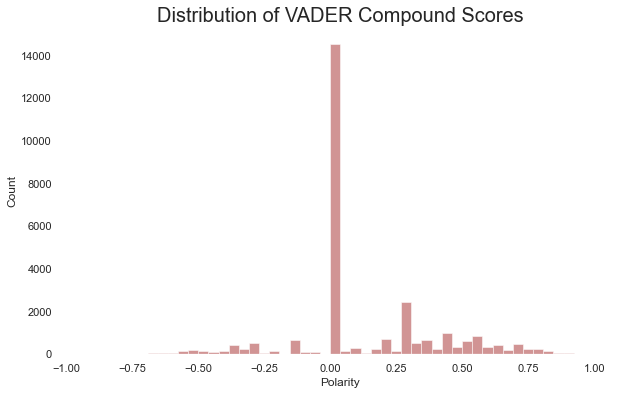

In [136]:
# Plot Vader Compound Scores
num_bins = 50
fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor("White")
n, bins, patches = plt.hist(df2.VComp, num_bins, facecolor='brown', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Distribution of VADER Compound Scores', fontsize = 20)
plt.show();

In [137]:
# How many reviews have sentiment above and below 0.05 threshold suggested in the documentation
print(df2[df2["VComp"] >= 0.05].shape[0]) # positive
print(df2[(df2["VComp"] <0.05) & (df2["VComp"] > -0.05)].shape[0]) # neutral
print(df2[df2["VComp"] <= -0.05].shape[0]) # negative

10556
14578
3301


Most tweets appear to be neutral or positive, very few are negative

## Can we Build a Predictive Model for Tweet Sentiment?

Including neutral sentiment tweets is more difficult in terms of building a predictive model, as this would be a multi-class classification rather than binary. Also neutral sentiment is not as clearly defined as positive and negative sentiment documents as they tend to lie on the decision boundary of a model. However, VADER classified the vast majority of tweets as neutral sentiment and this might be expected with the subject which is very factual and less likely to contain emotion. Therefore we will try to build a classifier that does include neutral sentiment but expect this to not be very successful.

In [138]:
# Classify the tweets according to the VADER compound sentiment score
s = df2[["text","VComp"]]

conditions = [(s["VComp"]>0.05),s["VComp"]<=-0.05,(s["VComp"] <0.05) & (s["VComp"] > -0.05)]
choices = [1,-1,0]

s["Score"] = np.select(conditions,choices,default = 'null')
s["Score"] = s["Score"].astype('int64')

In [139]:
s.head()

,text,VComp,Score
0,video i office minding business ... –david sol...,0.0000,0
1,price lumber lb_f since hitting ytd highs macy...,0.0000,0
2,says american dream dead,-0.5106,-1
3,barry silbert extremely optimistic bitcoin -- ...,0.3804,1
4,satellites avoid attacks space junk circling e...,-0.6249,-1


In [140]:
# Balance the dataset by taking equal numbers of each sentiment based on VADER's analysis
s.Score.value_counts()

 0    14578
 1    10556
-1     3301
Name: Score, dtype: int64

In [141]:
# Set dataframes
pos = s[s["Score"] == 1]
neg = s[s["Score"] == -1]
neut = s[s["Score"] == 0]

In [147]:
# Sample same amount from each and concat back to single dataframe and shuffle
pos = pos.sample(3300)
neg = neg.sample(3300)
neut = neut.sample(3300)

final = pd.concat([pos,neg,neut],axis = 0)
final = final.sample(frac=1)
final.Score.value_counts()

-1    3300
 1    3300
 0    3300
Name: Score, dtype: int64

In [152]:
final.head()

,text,VComp,Score,joined_text
10114,insider selling glu mobile inc. gluu vp sells ...,0.2960,1,insider selling glu mobile inc. gluu vp sells ...
13224,sysco co. syy expected announce quarterly sale...,0.0000,0,sysco co. syy expected announce quarterly sale...
19280,idra bmy mrk orphan drug designation fast trac...,0.3182,1,idra bmy mrk orphan drug designation fast trac...
4936,premarket pixy beat earnings wwe morgan ups go...,-0.1027,-1,premarket pixy beat earnings wwe morgan ups go...
18119,valuengine lowers omnicom group omc sell,-0.1280,-1,valuengine lowers omnicom group omc sell


In [153]:
# Set X and y and split into training and test sets

X = final["text"]
y = final["Score"]

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2)

In [162]:
# Create word string before vectorizing
X_train = X_train.apply(lambda x:''.join(x))
X_test = X_test.apply(lambda x: ''.join(x))

In [163]:
# Create vectorized text
tf_idf_vectorizer = TfidfVectorizer()
vector_train = tf_idf_vectorizer.fit_transform(X_train)
vector_test = tf_idf_vectorizer.transform(X_test)

In [165]:
# Specify models
nb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC(probability = True)

In [167]:
# Fit the models
nb.fit(vector_train, y_train)
lr.fit(vector_train, y_train)
rf.fit(vector_train, y_train)
svm.fit(vector_train, y_train)

SVC(probability=True)

In [170]:
# Predict against test set
y_prednb = nb.predict(vector_test)
y_predlr = lr.predict(vector_test)
y_predrf = rf.predict(vector_test)
y_predsvm = svm.predict(vector_test)

In [173]:
print(classification_report(y_test, y_prednb))

              precision    recall  f1-score   support

          -1       0.81      0.81      0.81       689
           0       0.80      0.77      0.78       626
           1       0.79      0.82      0.80       665

    accuracy                           0.80      1980
   macro avg       0.80      0.80      0.80      1980
weighted avg       0.80      0.80      0.80      1980



In [175]:
print(classification_report(y_test, y_predlr))

              precision    recall  f1-score   support

          -1       0.91      0.85      0.88       689
           0       0.81      0.89      0.85       626
           1       0.90      0.87      0.89       665

    accuracy                           0.87      1980
   macro avg       0.87      0.87      0.87      1980
weighted avg       0.87      0.87      0.87      1980



In [176]:
print(classification_report(y_test, y_predrf))

              precision    recall  f1-score   support

          -1       0.95      0.86      0.90       689
           0       0.81      0.95      0.88       626
           1       0.95      0.89      0.91       665

    accuracy                           0.90      1980
   macro avg       0.90      0.90      0.90      1980
weighted avg       0.90      0.90      0.90      1980



In [177]:
print(classification_report(y_test, y_predsvm))

              precision    recall  f1-score   support

          -1       0.93      0.87      0.90       689
           0       0.80      0.91      0.85       626
           1       0.93      0.88      0.90       665

    accuracy                           0.88      1980
   macro avg       0.89      0.88      0.88      1980
weighted avg       0.89      0.88      0.88      1980



The random forest model seems to have the best overall accuracy

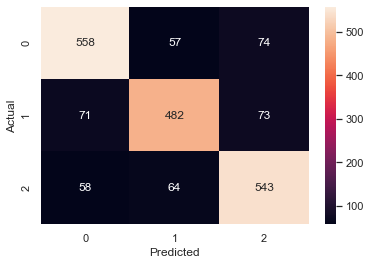

In [186]:
sns.heatmap(confusion_matrix(y_test, y_prednb), annot = True, fmt = "d")
plt.xlabel("Predicted")
plt.ylabel("Actual");

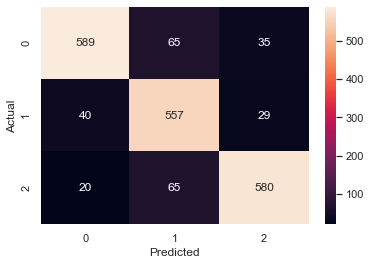

In [187]:
sns.heatmap(confusion_matrix(y_test, y_predlr), annot = True, fmt = "d")
plt.xlabel("Predicted")
plt.ylabel("Actual");

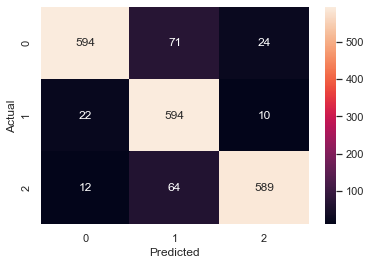

In [188]:
sns.heatmap(confusion_matrix(y_test, y_predrf), annot = True, fmt = "d")
plt.xlabel("Predicted")
plt.ylabel("Actual");

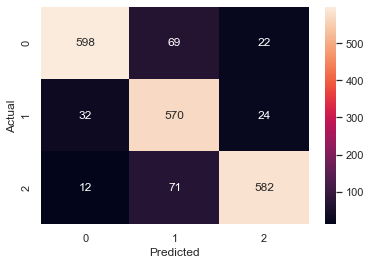

In [189]:
sns.heatmap(confusion_matrix(y_test, y_predsvm), annot = True, fmt = "d")
plt.xlabel("Predicted")
plt.ylabel("Actual");

* The models returned reasonable accuracy. 
* Accuracy can be used for evaluation as the dataset is balanced. 
* The random forest returned the best accuracy at 90%. 
* The model predicts the neutral comments better than positive or negative and performs worst in terms of recall in predicting negative tweets.